In [ ]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

from sklearn import model_selection #import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn import metrics  # mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score
from sklearn.feature_selection import SelectFromModel, RFECV

**Load Data**:

In [ ]:
# load training data prepared previously

df_train = pd.read_excel('/content/Final Dataset head.xlsx')
df_train.head()

,Unnamed: 0,id,cycle,setting1,setting2,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label 1,label 2
0,0,1,1,0.65625,0.692308,0.670881,0.596215,0.421968,0.282214,0.343328,...,0.347076,0.698789,0.375,0.567450,0.289574,0.500000,0.620099,142,0,0
1,1,1,2,0.34375,0.230769,0.304560,0.182965,0.504025,0.225240,0.573590,...,0.227709,0.687998,0.500,0.378570,0.336740,0.645455,0.645718,141,0,0
2,2,1,3,0.53125,0.538462,0.534520,0.419558,0.464814,0.346130,0.295640,...,0.533557,0.457542,0.500,0.357485,0.335740,0.700000,0.681104,140,0,0
3,3,1,4,0.77500,0.461538,0.678870,0.413249,0.391587,0.449867,0.385460,...,0.282359,0.198790,0.250,0.227640,0.289430,0.627273,0.620382,139,0,0
4,4,1,5,0.60000,0.461538,0.308790,0.435331,0.471306,0.357974,0.285285,...,0.337009,0.398760,0.125,0.297490,0.189750,0.618182,0.676008,138,0,0


In [ ]:
# load test data prepared previously

df_test = pd.read_excel('/content/Final Dataset head.xlsx')
df_test.head()

,Unnamed: 0,id,cycle,setting1,setting2,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label 1,label 2
0,0,1,1,0.65625,0.692308,0.670881,0.596215,0.421968,0.282214,0.343328,...,0.347076,0.698789,0.375,0.567450,0.289574,0.500000,0.620099,142,0,0
1,1,1,2,0.34375,0.230769,0.304560,0.182965,0.504025,0.225240,0.573590,...,0.227709,0.687998,0.500,0.378570,0.336740,0.645455,0.645718,141,0,0
2,2,1,3,0.53125,0.538462,0.534520,0.419558,0.464814,0.346130,0.295640,...,0.533557,0.457542,0.500,0.357485,0.335740,0.700000,0.681104,140,0,0
3,3,1,4,0.77500,0.461538,0.678870,0.413249,0.391587,0.449867,0.385460,...,0.282359,0.198790,0.250,0.227640,0.289430,0.627273,0.620382,139,0,0
4,4,1,5,0.60000,0.461538,0.308790,0.435331,0.471306,0.357974,0.285285,...,0.337009,0.398760,0.125,0.297490,0.189750,0.618182,0.676008,138,0,0


**Regression Modelling**:

Segment training and test data into features dataframe and labels series.

To make it easy to train models on different set of features, a variable to hold the set of features required was used to subset the original dataframes

In [ ]:
#Prepare data for regression model

# original features
features_orig = ['setting1','setting2','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# original + extracted fetures
features_adxf = ['setting1', 'setting2', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'RUL']

# features with low or no correlation with regression label
features_lowcr = ['s1', 's10', 's18','s19','s16','s5', 'setting1', 'setting2']

# features that have correlation with regression label
features_corrl = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20','s21']

# a variable to hold the set of features to experiment with
features = features_orig


X_train = df_train[features]
y_train = df_train['RUL']

X_test = df_test[features]
y_test = df_test['RUL']

Create a helper function to calculate regression metrics

In [ ]:
def get_regression_metrics(model, actual, predicted):

    """Calculate main regression metrics.

    Args:
        model (str): The model name identifier
        actual (series): Contains the test label values
        predicted (series): Contains the predicted values

    Returns:
        dataframe: The combined metrics in single dataframe


    """
    regr_metrics = {
                        'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
                        'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
                        'R^2' : metrics.r2_score(actual, predicted),
                        'Explained Variance' : metrics.explained_variance_score(actual, predicted)
                   }

    #return reg_metrics
    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

Create a helper function to plot the oefficients weights or feature importance

In [ ]:
def plot_features_weights(model, weights, feature_names, weights_type='c'):

    """Plot regression coefficients weights or feature importance.

    Args:
        model (str): The model name identifier
        weights (array): Contains the regression coefficients weights or feature importance
        feature_names (list): Contains the corresponding features names
        weights_type (str): 'c' for 'coefficients weights', otherwise is 'feature importance'

    Returns:
        plot of either regression coefficients weights or feature importance


    """
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({'Weights':weights}, feature_names)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px,py))
    label = ' Coefficients' if weights_type =='c' else ' Features Importance'
    plt.xlabel(model + label)
    plt.gca().legend_ = None

Create a helper function to plot the regression residuals

In [ ]:
def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):

    """Print the regression residuals.

    Args:
        model (str): The model name identifier
        y_train (series): The training labels
        y_train_pred (series): Predictions on training data
        y_test (series): The test labels
        y_test_pred (series): Predictions on test data

    Returns:
        Plot of regression residuals

    """

    plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-50, xmax=400, color='red', lw=2)
    plt.title(model + ' Residuals')
    plt.show()

Using the above functions let us model and evaluate some regression algorithms

In [ ]:
#try linear regression

linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

linreg_metrics = get_regression_metrics('Linear Regression', y_test, y_test_predict)
linreg_metrics

R^2 training: 1.000, R^2 test: 1.000


,Linear Regression
Root Mean Squared Error,0.0
Mean Absolute Error,0.0
R^2,1.0
Explained Variance,1.0


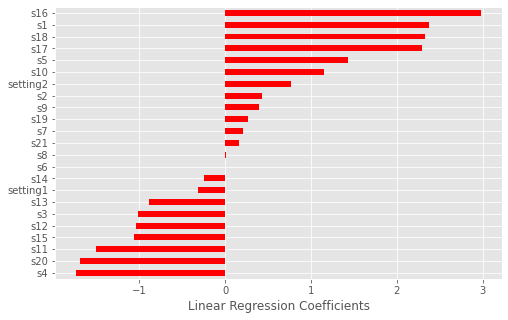

In [ ]:
plot_features_weights('Linear Regression', linreg.coef_, X_train.columns, 'c')

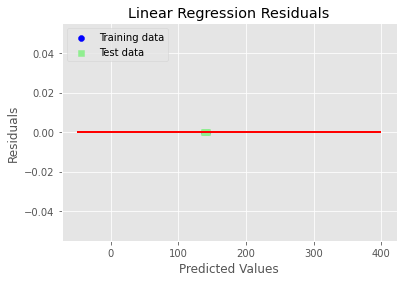

In [ ]:
plot_residual('Linear Regression', y_train_predict, y_train, y_test_predict, y_test)

In [ ]:
#try LASSO

lasso = linear_model.Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

y_test_predict = lasso.predict(X_test)
y_train_predict = lasso.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

lasso_metrics = get_regression_metrics('LASSO', y_test, y_test_predict)

lasso_metrics

R^2 training: 1.000, R^2 test: 1.000


,LASSO
Root Mean Squared Error,0.014406
Mean Absolute Error,0.013923
R^2,0.999896
Explained Variance,0.999896


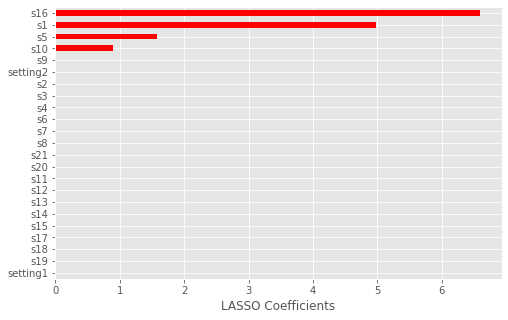

In [ ]:
plot_features_weights('LASSO', lasso.coef_, X_train.columns, 'c')

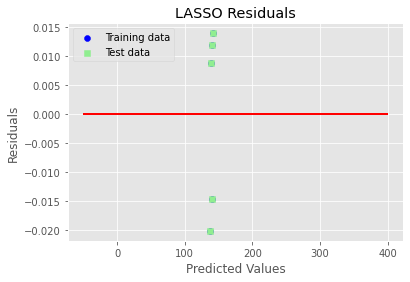

In [ ]:
plot_residual('LASSO', y_train_predict, y_train, y_test_predict, y_test)

In [ ]:
#try ridge

rdg = linear_model.Ridge(alpha=0.01)
rdg.fit(X_train, y_train)

y_test_predict = rdg.predict(X_test)
y_train_predict = rdg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

rdg_metrics = get_regression_metrics('Ridge Regression', y_test, y_test_predict)
rdg_metrics


R^2 training: 0.998, R^2 test: 0.998


,Ridge Regression
Root Mean Squared Error,0.056251
Mean Absolute Error,0.046745
R^2,0.998418
Explained Variance,0.998418


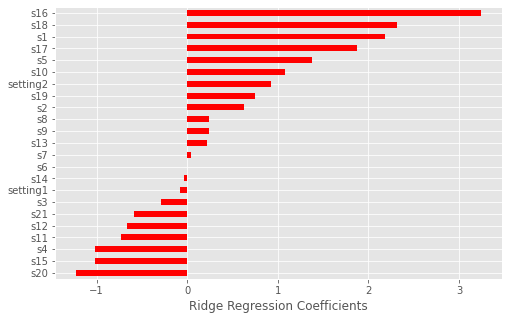

In [ ]:
plot_features_weights('Ridge Regression', rdg.coef_, X_train.columns, 'c')

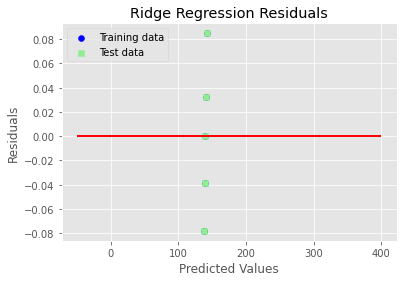

In [ ]:
plot_residual('Ridge Regression', y_train_predict, y_train, y_test_predict, y_test)

In [ ]:
#try Polynomial Regression

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)


polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)

y_test_predict = polyreg.predict(X_test_poly)
y_train_predict = polyreg.predict(X_train_poly)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

polyreg_metrics = get_regression_metrics('Polynomial Regression', y_test, y_test_predict)
polyreg_metrics

R^2 training: 1.000, R^2 test: 1.000


,Polynomial Regression
Root Mean Squared Error,0.0
Mean Absolute Error,0.0
R^2,1.0
Explained Variance,1.0


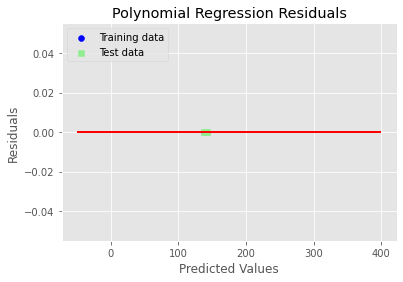

In [ ]:
plot_residual('Polynomial Regression', y_train_predict, y_train, y_test_predict, y_test)

Polynomial Regression has scored better than linear models

In [ ]:
#try Decision Tree regressor

#dtrg = DecisionTreeRegressor(max_depth=8, max_features=5, random_state=123) # selected features
dtrg = DecisionTreeRegressor(max_depth=7, random_state=123)
dtrg.fit(X_train, y_train)

y_test_predict = dtrg.predict(X_test)
y_train_predict = dtrg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

dtrg_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_test_predict)
dtrg_metrics

R^2 training: 1.000, R^2 test: 1.000


,Decision Tree Regression
Root Mean Squared Error,0.0
Mean Absolute Error,0.0
R^2,1.0
Explained Variance,1.0


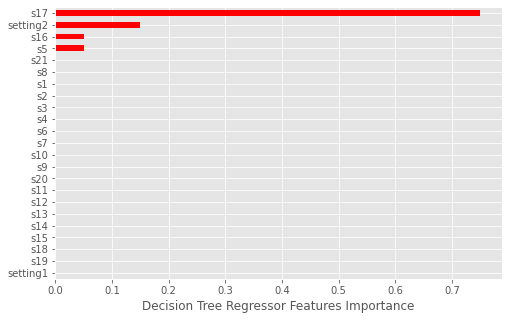

In [ ]:
plot_features_weights('Decision Tree Regressor', dtrg.feature_importances_, X_train.columns, 't' )


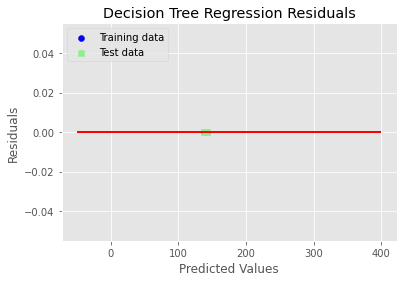

In [ ]:
plot_residual('Decision Tree Regression', y_train_predict, y_train, y_test_predict, y_test)

In [ ]:
#try Random Forest

#rf = RandomForestRegressor(n_estimators=100, max_features=2, max_depth=4, n_jobs=-1, random_state=1) # selected features
rf = RandomForestRegressor(n_estimators=100, max_features=3, max_depth=4, n_jobs=-1, random_state=1) # original features
#rf = RandomForestRegressor(n_estimators=100, max_features=3, max_depth=7, n_jobs=-1, random_state=1) # orig + extrcted

rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
y_train_predict = rf.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)),
      (metrics.r2_score(y_test, y_test_predict))))

rf_metrics = get_regression_metrics('Random Forest Regression', y_test, y_test_predict)
rf_metrics

R^2 training: 0.831, R^2 test: 0.831


,Random Forest Regression
Root Mean Squared Error,0.582168
Mean Absolute Error,0.488000
R^2,0.830540
Explained Variance,0.830828


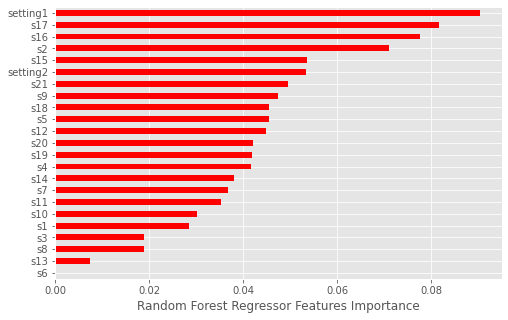

In [ ]:
plot_features_weights('Random Forest Regressor', rf.feature_importances_, X_train.columns, 't' )

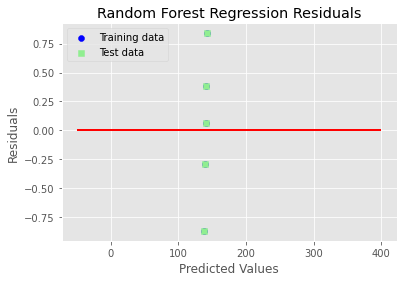

In [ ]:
plot_residual('Random Forest Regression', y_train_predict, y_train, y_test_predict, y_test)

regression residuals were not randomly spread across the average value of the residuals. This could be improved by fixing the data (e.g. outliers, resampling) or model parameters tuning.

Let us view predicted values

In [ ]:
# view predictions vs actual

rf_pred_dict = {
                'Actual' : y_test,
                'Prediction' : y_test_predict
            }

rf_pred = pd.DataFrame.from_dict(rf_pred_dict).T
rf_pred

,0,1,2,3,4
Actual,142.00,141.00,140.00,139.00,138.00
Prediction,141.16,140.62,139.94,139.29,138.87


**Compare all regression models tested**

In [ ]:
#regression metrics comparison before feature engineering

reg_metrics_bfe = pd.concat([linreg_metrics, lasso_metrics, rdg_metrics, dtrg_metrics, polyreg_metrics, rf_metrics], axis=1)
reg_metrics_bfe

,Linear Regression,LASSO,Ridge Regression,Decision Tree Regression,Polynomial Regression,Random Forest Regression
Root Mean Squared Error,0.0,0.014406,0.056251,0.0,0.0,0.582168
Mean Absolute Error,0.0,0.013923,0.046745,0.0,0.0,0.488000
R^2,1.0,0.999896,0.998418,1.0,1.0,0.830540
Explained Variance,1.0,0.999896,0.998418,1.0,1.0,0.830828


**Regression Summary:**

In accordance with our analysis in the data exploratory phase, non-linear regression models like Polynomial and Random Forest performed better than linear models like OLS, LASSO and Ridge regression. Random Forest clearly outperformed other models scoring RMSE of 28.63 cycles, i.e. the model predicts TTF within average error range of ±28.63 cycles.

The hyper-parameter tuning for the Random Forest Regressor, LASSO, and Ridge models was done manually, but Grid Search or Random Search with Cross Validation could be used for better processing.